<a href="https://colab.research.google.com/github/AnshPunia26/Audio_classification/blob/main/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.8.1 matplotlib
!pip install tensorflow_io==0.23.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 62.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing inst

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
#Add labels and adding flags as 0's and 1's on the data
positives = tf.data.Dataset.zip((tf.data.Dataset.list_files(os.path.join("/content/drive/MyDrive/data", "Parsed_Capuchinbird_Clips")+'/*.wav'), tf.data.Dataset.from_tensor_slices(tf.ones(len(tf.data.Dataset.list_files(os.path.join("/content/drive/MyDrive/data", "Parsed_Capuchinbird_Clips")+'/*.wav'))))))
negatives = tf.data.Dataset.zip((tf.data.Dataset.list_files(os.path.join("/content/drive/MyDrive/data", "Parsed_Not_Capuchinbird_Clips")+'/*.wav'), tf.data.Dataset.from_tensor_slices(tf.zeros(len(tf.data.Dataset.list_files(os.path.join("/content/drive/MyDrive/data", "Parsed_Not_Capuchinbird_Clips")+'/*.wav'))))))
data = positives.concatenate(negatives)

In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label


In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(8)
data = data.prefetch(8)

In [ ]:
len(data)

102

In [ ]:
train = data.take(52)
test = data.skip(52).take(50)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 128)               385240192 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 385,240,985
Trainable params: 385,240,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(train, epochs=5, validation_data=test)

Epoch 1/5
52/52 [==============================] - 720s 8s/step - loss: 19.4720 - recall: 0.7788 - precision: 0.7719 - val_loss: 2.6300 - val_recall: 0.7182 - val_precision: 0.9634
Epoch 2/5
52/52 [==============================] - 379s 7s/step - loss: 1.2528 - recall: 0.8485 - precision: 0.9333 - val_loss: 0.2703 - val_recall: 0.8190 - val_precision: 0.9556
Epoch 3/5
52/52 [==============================] - 381s 7s/step - loss: 0.0967 - recall: 0.9138 - precision: 0.9636 - val_loss: 0.0457 - val_recall: 0.9554 - val_precision: 0.9640
Epoch 4/5
52/52 [==============================] - 374s 7s/step - loss: 0.1103 - recall: 0.9640 - precision: 0.9727 - val_loss: 0.0294 - val_recall: 1.0000 - val_precision: 0.9612
Epoch 5/5
52/52 [==============================] - 375s 7s/step - loss: 0.0651 - recall: 0.9907 - precision: 0.9727 - val_loss: 0.0239 - val_recall: 0.9647 - val_precision: 0.9880


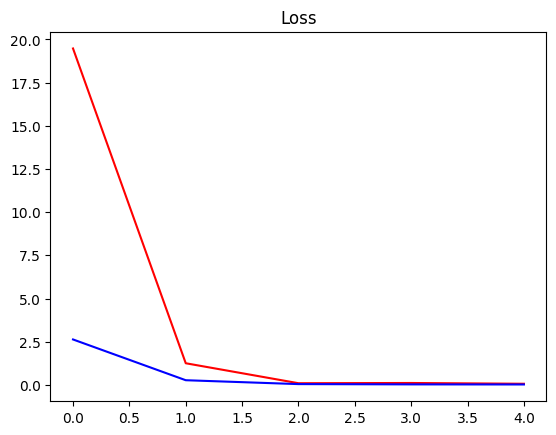

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

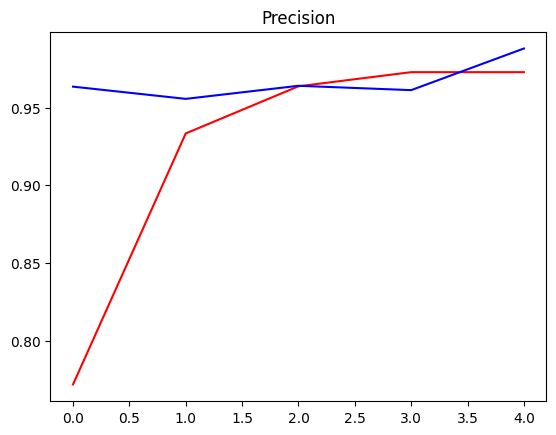

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

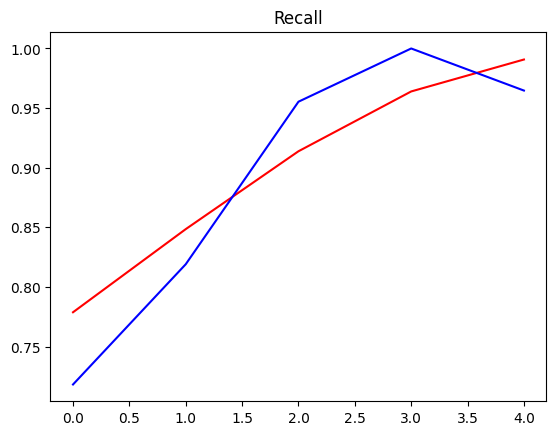

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
y_test

array([1., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
X_test

array([[[[2.64953449e-03],
         [4.82253432e-02],
         [6.94808066e-02],
         ...,
         [1.50676613e-04],
         [4.38710122e-05],
         [1.81756914e-05]],

        [[2.69472562e-02],
         [5.03595769e-02],
         [1.03639223e-01],
         ...,
         [1.82707809e-04],
         [5.89103001e-05],
         [1.94013119e-05]],

        [[1.37522072e-02],
         [5.34432903e-02],
         [1.35763213e-01],
         ...,
         [1.86483536e-04],
         [5.49748474e-05],
         [6.64219260e-06]],

        ...,

        [[5.16159795e-02],
         [2.29117163e-02],
         [4.24590260e-02],
         ...,
         [1.64094788e-04],
         [1.10107409e-04],
         [3.67797911e-05]],

        [[4.67969626e-02],
         [3.81227881e-02],
         [4.65107299e-02],
         ...,
         [1.45968806e-04],
         [9.10522795e-05],
         [2.91019678e-05]],

        [[5.81147149e-02],
         [6.05808198e-02],
         [3.70881781e-02],
         ...,
 

In [ ]:
X_test.shape

(8, 1491, 257, 1)

In [ ]:
yhat = model.predict(X_test)
yhat

array([[1.0000000e+00],
       [1.0000000e+00],
       [3.5691708e-02],
       [2.8702849e-05],
       [4.2964076e-22],
       [1.2308605e-16],
       [2.9743493e-05],
       [3.6534196e-08]], dtype=float32)

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
y_test

array([1., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
yhat

[1, 1, 0, 0, 0, 0, 0, 0]

In [ ]:
X_test2, y_test2 = test.as_numpy_iterator().next()

In [ ]:
X_test2

array([[[[2.41034180e-02],
         [2.47641392e-02],
         [1.90400593e-02],
         ...,
         [8.78835781e-05],
         [5.75332051e-05],
         [2.30967999e-05]],

        [[3.83335873e-02],
         [3.49600092e-02],
         [3.03480066e-02],
         ...,
         [9.21558749e-05],
         [3.10577088e-05],
         [6.84522092e-06]],

        [[4.78482842e-02],
         [4.37643193e-02],
         [3.50359045e-02],
         ...,
         [7.64262295e-05],
         [3.44879081e-05],
         [2.26702541e-05]],

        ...,

        [[2.04474702e-02],
         [1.58414487e-02],
         [1.15036536e-02],
         ...,
         [2.66493826e-05],
         [1.46741295e-05],
         [2.43904069e-05]],

        [[1.62043050e-02],
         [8.45388975e-03],
         [5.31271147e-03],
         ...,
         [1.08815711e-05],
         [2.38244265e-05],
         [9.47993249e-06]],

        [[1.81338862e-02],
         [1.26900226e-02],
         [8.83673690e-03],
         ...,
 

In [ ]:
y_test2

array([1., 0., 1., 1., 1., 1., 0., 1.], dtype=float32)

In [ ]:
yhat2 = model.predict(X_test2)
yhat2

array([[5.9900254e-01],
       [1.1596894e-04],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [9.8990822e-01]], dtype=float32)

In [ ]:
yhat2 = [1 if prediction > 0.5 else 0 for prediction in yhat2]

In [ ]:
yhat2

[1, 0, 1, 1, 1, 1, 0, 1]

In [ ]:
X_test3, y_test3 = test.as_numpy_iterator().next()

In [ ]:
X_test3

array([[[[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00]],

        [[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00]],

        [[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00]],

        ...,

        [[3.40477303e-02],
         [3.12296338e-02],
         [3.81211005e-02],
         ...,
         [2.88126955e-07],
         [3.17641422e-07],
         [2.92435288e-07]],

        [[2.25308836e-02],
         [2.12411992e-02],
         [2.03913487e-02],
         ...,
         [4.35687355e-07],
         [3.96452549e-07],
         [1.63912773e-07]],

        [[1.06373057e-02],
         [8.47402588e-03],
         [5.89918112e-03],
         ...,
 

In [ ]:
y_test3

array([1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
yhat3 = model.predict(X_test3)
yhat3

array([[8.83745670e-01],
       [1.07978725e-04],
       [5.80903834e-05],
       [5.50574994e-12],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.61351466e-03],
       [1.73494573e-05]], dtype=float32)

In [ ]:
yhat3 = [1 if prediction > 0.5 else 0 for prediction in yhat3]

In [ ]:
yhat3

[1, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join("/content/drive/MyDrive/data/Forest_Recordings","recording_00.mp3")

In [ ]:
os.path.exists(mp3)

True

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
wav

<tf.Tensor: shape=(2880666,), dtype=float32, numpy=
array([ 8.1433272e-12, -5.7019250e-12, -5.3486417e-12, ...,
       -1.1291276e-02, -1.4230422e-02, -3.0555837e-03], dtype=float32)>

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
len(samples)

1

In [ ]:
samples.shape

(1, 48000)

In [ ]:
len(audio_slices)

60

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram


In [ ]:
yhat10 = model.predict(audio_slices)
yhat10 = [1 if prediction > 0.7 else 0 for prediction in yhat10]

In [ ]:
yhat10

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
from itertools import groupby

In [ ]:
yhat10 = [key for key, group in groupby(yhat10)]
calls = tf.math.reduce_sum(yhat10).numpy()
yhat10
calls

5

In [ ]:
results = {}
for file in os.listdir(os.path.join('/content/drive/MyDrive/data', 'Forest_Recordings')):
    FILEPATH = os.path.join('/content/drive/MyDrive/data','Forest_Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

In [ ]:
len(results)

100

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.9 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 3,
 'recording_17.mp3': 3,
 'recording_19.mp3': 0,
 'recording_18.mp3': 4,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 4,
 'recording_27.mp3': 0,
 'recording_26.mp3': 2,
 'recording_24.mp3': 0,
 'recording_25.mp3': 2,
 'recording_29.mp3': 0,
 'recording_28.mp3': 4,
 'recording_31.mp3': 1,
 'recording_30.mp3': 2,
 'recording_32.mp3': 2,
 'recording_35.mp3': 0,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_38.mp3': 1,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_39.mp3': 4,
 'recording_42.mp3': 0,
 'recording_41.

In [ ]:
import csv

with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])